# satCORPS composite legacy file with sidecar-based subsetting


In [1]:
import pystare
import starepandas
import geopandas
import pandas

import numpy
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import datetime

import regionmask
import xarray
from shapely.geometry import Polygon

import dask

plot_options = {'projection': ccrs.PlateCarree(central_longitude=0.0)
                ,'transform': ccrs.Geodetic()}


In [2]:
class timings_store:
    def __init__(self):
        self.timings = {}
        return
   
    def add(self,key,value,verbose=True):
        self.timings[key] = value
        if verbose:
            print("{} {}".format(key,value))
        return self
    
    def print_report(self,fmt="{:30} {:>6.2f}",key=None,grepv=None):
        for i, (k,v) in enumerate(self.timings.items()):
            if key is None:
                if not grepv is None:
                    if not grepv in k:
                        print(fmt.format(k,v.total_seconds()))
                else:
                    print(fmt.format(k,v.total_seconds()))
            else:
                if key in k:
                    if not grepv is None:
                        if not grepv in k:
                            print(fmt.format(k,v.total_seconds()))
                    else:
                        print(fmt.format(k,v.total_seconds()))
        return self
    
timings = timings_store()

## Create and install a user defined granule loader to plug into starepandas

In [3]:
from starepandas.io.granules import Granule

class satcorps_composite(Granule):

    def __init__(self, file_path, sidecar_path=None):
        super(satcorps_composite, self).__init__(file_path, sidecar_path)
        self.nom_res = ''
        self.companion_prefix = 'composite'
        
        self.source_nc = starepandas.io.s3.nc4_dataset_wrapper(self.file_path, 'r', format='NETCDF4')
        self.lat = None
        self.lon = None
        self.data = {}

    def read_data(self):
        if False:
            dataset_names = ['time' # "days since 1858-11-17T00:00:00.000"
                             ,'map_data/BT_10.8um']

            for dataset_name in dataset_names:
                self.data[dataset_name] = self.source_nc.select(dataset_name).get()
        
#        self.data['time'] = self.source_nc['time'][:].astype(numpy.double)

        ds_names = {
            'BT_10_8um':'BT_10.8um',
            'BT_12_0um':'BT_12.0um',
            'BT_3_75um':'BT_3.75um',
            'BT_6_75um':'BT_6.75um'
        }
        for ds_name in ds_names.keys():
            self.data[ds_name] = self.source_nc.groups['map_data'][ds_names[ds_name]][:].astype(numpy.double)
    
        lat = self.source_nc.groups['map_data']['lat'][:].astype(numpy.double); nlat=len(lat)
        lon = self.source_nc.groups['map_data']['lon'][:].astype(numpy.double); nlon=len(lon)
        self.data['lats'] = numpy.ascontiguousarray(numpy.tile(lat,(nlon,1)).transpose())
        self.data['lons'] = numpy.tile(lon,(nlat,1))

starepandas.io.granules.granule_factory_library['composite']=satcorps_composite

starepandas.io.granules.granule_factory_library

{'MOD05|MYD05': starepandas.io.granules.modis.Mod05,
 'MOD09|MYD09': starepandas.io.granules.modis.Mod09,
 'VNP02DNB|VJ102DNB': starepandas.io.granules.viirsl2.VNP02DNB,
 'VNP03DNB|VJ103DNB': starepandas.io.granules.viirsl2.VNP03DNB,
 'VNP03MOD|VJ103MOD': starepandas.io.granules.viirsl2.VNP03MOD,
 'CLDMSKL2VIIRS': starepandas.io.granules.viirsl2.CLDMSKL2VIIRS,
 'SSMIS': starepandas.io.granules.ssmis.SSMIS,
 'ATMS': starepandas.io.granules.atms.ATMS,
 'composite': __main__.satcorps_composite}

## Get the shapefile information for US states and territories and add STARE coordinates

!wget https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip

In [4]:
start0 = datetime.datetime.now()

In [5]:
# Get some locales
if True:
    states = geopandas.read_file('tl_2019_us_state.zip')
    states = starepandas.STAREDataFrame(states)
    sids = states.make_sids(n_workers=50, resolution=10)
    states.set_sids(sids, inplace=True)
    trixels = states.make_trixels(n_workers=50, wrap_lon=False)
    states.set_trixels(trixels, inplace=True)
    states.split_antimeridian(inplace=True)

## Select shapes to construct roi

- Note we set the resolution at which to cover the ROI. That is, the finest resolution trixel to be used in the cover.

In [6]:
if True:
    
    roi_resolution = 11
    
    # roi=states[states.NAME=='Hawaii']
    # roi=states[states.NAME=='California']
    
    if False:
        conus = states[states.NAME=='Hawaii'] # Abuse 'conus'
    
    if True:
        conus = states[~states['NAME'].isin(['Alaska'
                                     ,'Hawaii'
                                     ,'United States Virgin Islands'
                                     ,'Commonwealth of the Northern Mariana Islands'
                                     ,'Guam'
                                     ,'American Samoa'
                                     ,'Puerto Rico'])]
    # roi = conus
    
    conus1 = starepandas.STAREDataFrame(conus.dissolve())
    
    # Set resolution
    conus1.set_sids(conus1.make_sids(resolution=roi_resolution),inplace=True)
    conus1.set_trixels(conus1.make_trixels(),inplace=True)
    
    roi = starepandas.STAREDataFrame(sids=conus1.stare_dissolve(n_workers=50,aggfunc='first'))
    roi.set_trixels(roi.make_trixels(),inplace=True)

if False:
    roi.to_hdf('conus-roi.h5','stare_indexed') # one way to store roi

In [7]:
timings.add('time to read roi data and make roi stare index',datetime.datetime.now() - start0)

time to read roi data and make roi stare index 0:08:49.816645


In [8]:
# starepandas.STAREDataFrame(conus1)

## A few alternative regions

In [9]:
# Get some locales
if False:
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world.sort_values(by='name', inplace=True)
    world = starepandas.STAREDataFrame(world)
    
    if False:
        world.plot(trixels=False)
        
if False:
    roi = world[world.name=='United States of America']
    # roi = world[world.name=='Bahamas']
    # roi = world[world.name=='Vanuatu']
    # roi = world[world.name=='Iceland']
    roi.set_sids(roi.make_sids(resolution=7),inplace=True)
    roi.set_trixels(roi.make_trixels(),inplace=True)

## Take a look at the ROI

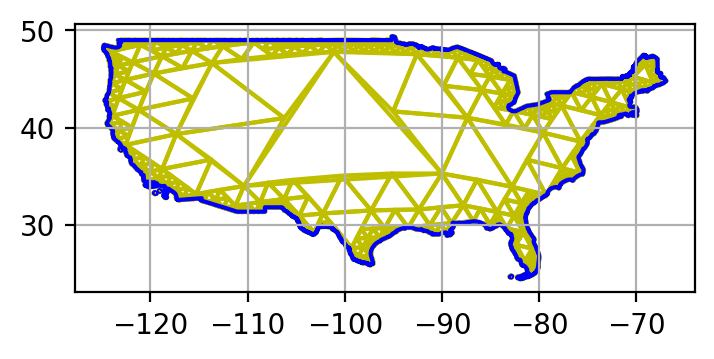

In [10]:
# Show the ROI in STARE
if True:
    fig, ax = plt.subplots(figsize=(4,4), dpi=200)
    ax.grid(True)


    roi.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=1)
    conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)

    del fig,ax

## Load the composite granule and its precomputed sidecar

In [11]:
start0 = datetime.datetime.now()

In [12]:
# Load the granule
if True:
    granule_name = 'ignored/satCORPS/composite_20220420_2019.182.0230.nc'
    composite = starepandas.read_granule(granule_name
                                         ,sidecar=True
                                         ,sidecar_path='ignored/satCORPS/satCORPS_composite_stare.nc')
    timings.add('time to read granule with stare sidecar',datetime.datetime.now() - start0)

time to read granule with stare sidecar 0:00:30.010702


## Get STARE HTM spatial indices (coordinates) that cover the intersection of the ROI and the composite granule.

In [13]:
start0 = datetime.datetime.now()

In [14]:
# a = composite.stare_intersects(roi['sids'].iloc[0],n_workers=50)
a = composite.stare_intersects(roi['sids'].iloc[:].to_numpy(),n_workers=36)

timings.add('calculate intersection (make "mask")',datetime.datetime.now() - start0)

calculate intersection (make "mask") 0:00:38.078519


## Subset the composite down to the ROI

In [15]:
start0 = datetime.datetime.now()

composite_subset = composite[a]

timings.add('apply "mask" to subset the data',datetime.datetime.now() - start0)

apply "mask" to subset the data 0:00:00.118456


## Take a look at the subsetted data

In [16]:
start0 = datetime.datetime.now()

time to start plot 0:00:00.229342


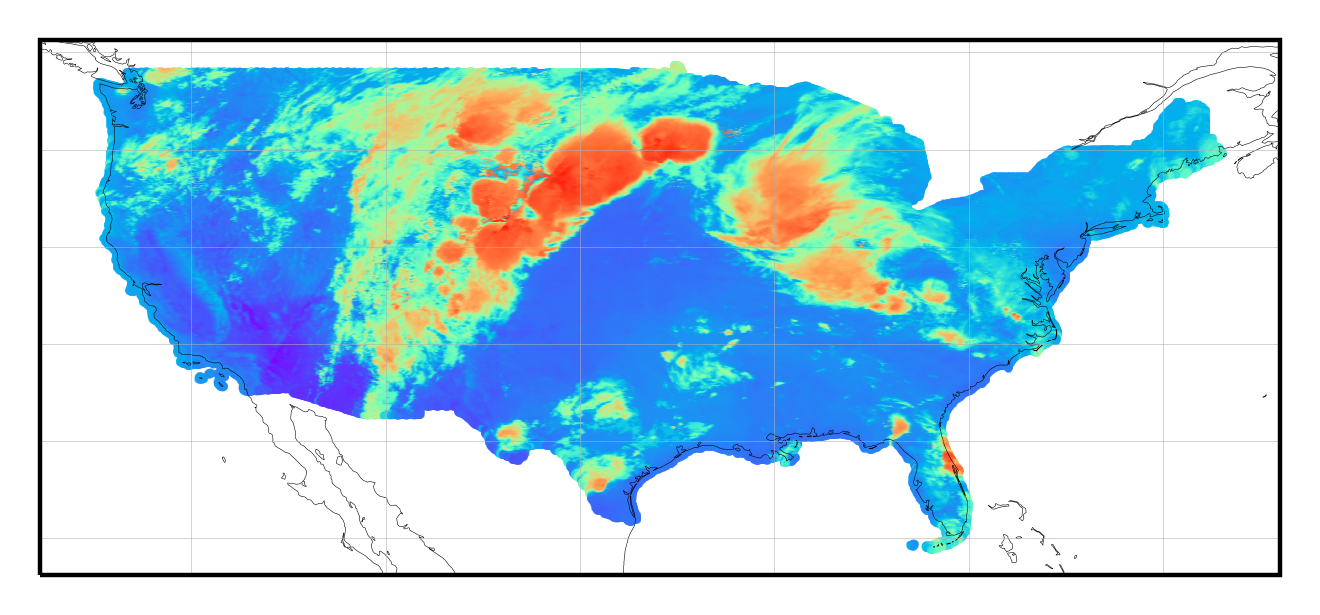

In [17]:
fig, ax = plt.subplots(figsize=(4,4), dpi=400
                       ,subplot_kw=plot_options
                      )
ax.gridlines(linewidth=0.1)
# ax.set_global()
ax.coastlines(linewidth=0.1)
# ax.grid(True)
if False:
    # x0 = 166; y0 = -15; dlim = 0.5
    # x0 = 165.5; y0 = -17.5; dlim = 3.75
    # dlimx = dlim; dlimy = dlim
    x0 = -127; y0 = 24; dlimx = 61; dlimy = 27
    
    ax.set_xlim(x0,x0+dlimx)
    ax.set_ylim(y0,y0+dlimy)

    marker_size=40.0/(dlim**2) # good for 'o'
    marker_size=27.0/(dlim**2) # good for 's'
    marker_alpha=0.5
else:
    ax.set_aspect('equal')
    marker_size=0.05
    marker_alpha=0.5
    
marker='s'

# jdf1.plot(ax=ax,column='map_data/BT_12.0m',zorder=1,cmap='OrRd',trixels=True)
# jdf1.plot(ax=ax,zorder=1,color='red',trixels=False,boundary=True)

ax.scatter(composite_subset['lons']
           ,composite_subset['lats']
           ,s=marker_size
           ,c=composite_subset['BT_12_0um']
           ,alpha=marker_alpha
#            ,cmap='nipy_spectral'
           ,cmap='rainbow_r'
           ,marker=marker
           ,rasterized=True
           ,transform=ccrs.PlateCarree()
                               )
# plt.scatter(jdf1['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)
# plt.scatter(jdf1['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)

# roi.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.5)
# conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='yellow', zorder=1, linewidth=1.5)
    
del fig,ax

timings.add('time to start plot',datetime.datetime.now() - start0)

In [18]:
timings.add('time from plot start to render end',datetime.datetime.now() - start0)

time from plot start to render end 0:00:13.912991


## Timing report summary

In [19]:
timings.print_report(fmt="{:70} {:>6.2f}")

time to read roi data and make roi stare index                         529.82
time to read granule with stare sidecar                                 30.01
calculate intersection (make "mask")                                    38.08
apply "mask" to subset the data                                          0.12
time to start plot                                                       0.23
time from plot start to render end                                      13.91
